In [1]:
# %tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.keras import backend as K

logger = tf.get_logger()

class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [2]:
#downloading attention layer for overcoming the problem of long sequences

In [3]:
pip install AttentionLayer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement AttentionLayer (from versions: none)
ERROR: No matching distribution found for AttentionLayer


In [4]:
pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
pip install keras-self-attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18912 sha256=4d57de148a70b2a3e6aa9473fdd8f55cb1921bf3c3d5f65569f1cabdfe166c88
  Stored in directory: /root/.cache/pip/wheels/95/b1/a8/5ee00cc137940b2f6fa198212e8f45d813d0e0d9c3a04035a3
Successfully built keras-self-attention


In [6]:
from tensorflow.keras.layers import Attention
from tensorflow.keras.layers import Layer

In [7]:
#importing libraries
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras_preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
#reading data
data=pd.read_csv("/content/drive/MyDrive/nlp_project/news_summary.csv",encoding='latin-1')

In [10]:
#removing duplicate and NA values
data.drop_duplicates(subset=['ctext'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)   #dropping na

In [11]:
#a predefined dictionary for expanding contractions
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [12]:
#printing the first 10 articles
data['ctext'][:10]

0    The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart o...
1    From her special numbers to TV?appearances, Bollywood actor Malaika Arora Khan has managed to carve her own identity. The actor, who made her debut in the Hindi film industry with the blockbuster ...
2    The Indira Gandhi Institute of Medical Sciences (IGIMS) in Patna amended its marital declaration form on Thursday, replacing the word ?virgin? with ?unmarried? after controversy.Until now, new rec...
3    Lashkar-e-Taiba's Kashmir commander Abu Dujana was killed in an encounter in a village in Pulwama district of Jammu and Kashmir earlier this week. Dujana, who had managed to give the security forc...
4    Hotels in Mumbai and other Indian cities are to train their staff to spot signs of sex trafficking such as frequent requests for bed linen changes or a "Do not disturb" sign l

In [13]:
#preprocessing for the articles
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower() #converting everything to lowercase
    newString = BeautifulSoup(newString, "lxml").text #removing html tags
    newString = re.sub(r'\([^)]*\)', '', newString) #removing any text inside parenthesis
    newString = re.sub('"','', newString) #removing punctuations
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")]) #contraction mapping
    newString = re.sub(r"'s\b","",newString) #removing 's
    newString = re.sub("[^a-zA-Z]", " ", newString) #removing special characters
    tokens = [w for w in newString.split() if not w in stop_words] #removing stopwords
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short words
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['ctext']:
    cleaned_text.append(text_cleaner(t))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
#printing first 10 summaries
data['text'][:10]

0    The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The...
1    Malaika Arora slammed an Instagram user who trolled her for "divorcing a rich man" and "having fun with the alimony". "Her life now is all about wearing short clothes, going to gym or salon, enjoy...
2    The Indira Gandhi Institute of Medical Sciences (IGIMS) in Patna on Thursday made corrections in its Marital Declaration Form by changing 'Virgin' option to 'Unmarried'. Earlier, Bihar Health Mini...
3    Lashkar-e-Taiba's Kashmir commander Abu Dujana, who was killed by security forces, said "Kabhi hum aage, kabhi aap, aaj aapne pakad liya, mubarak ho aapko (Today you caught me. Congratulations)" a...
4    Hotels in Maharashtra will train their staff to spot signs of sex trafficking, including frequent requests for bed linen changes and 'Do not disturb' signs left on room doors 

In [15]:
#preprocessing for summaries
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in data['text']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [16]:
#adding start and end special tokens at the beginning and end of the summary
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')
for i in range(5):
    print("Article:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")


Article: daman diu administration wednesday withdrew circular asked women staff tie rakhis male colleagues order triggered backlash employees ripped apart social media union territory administration forced retreat within hours issuing circular made compulsory staff celebrate rakshabandhan workplace decided celebrate festival rakshabandhan august connection offices departments shall remain open celebrate festival collectively suitable time wherein lady staff shall tie rakhis colleagues order issued august gurpreet singh deputy secretary said ensure one skipped office attendance report sent government next evening two notifications one mandating celebration rakshabandhan withdrawing mandate issued daman diu administration day apart circular withdrawn one line order issued late evening department personnel administrative reforms circular ridiculous sensitivities involved government dictate tie rakhi maintain professionalism workplace official told hindustan times earlier day refused ident

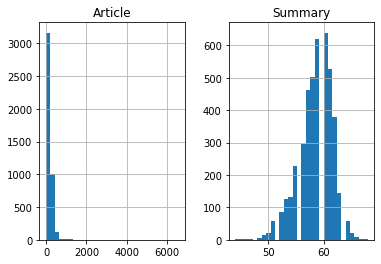

In [17]:
#calculating the distribution of the sequences
import matplotlib.pyplot as plt
article_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      article_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'Article':article_word_count, 'Summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [44]:
max_len_article=450
max_len_summary=60

In [45]:
#splitting the dataset into training-90% and validation set-10% 
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True) 

In [46]:
#creating the tokenizer of the articles to convert word sequences into integer sequences
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_article, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_article, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

% of rare words in vocabulary: 62.325623054703414
Total Coverage of rare words: 5.459945213161783


In [47]:
x_voc_size, len(x_tr)

(44660, 3906)

In [48]:
#creating the tokenizer of the summaries to convert word sequences into integer sequences
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

% of rare words in vocabulary: 75.78218159105104
Total Coverage of rare words: 10.90235442505781


In [49]:
y_voc_size,len(y_tr)

(17612, 3906)

**Model Building**

In [50]:
#building 3-stacked LSTM for encoder
from keras import backend as K 
K.clear_session() 
latent_dim = 500

# Encoder 
encoder_inputs = Input(shape=(max_len_article,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.2) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.2) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.2) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.2) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 450)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 450, 500)     22330000    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 450, 500),   2002000     ['embedding[0][0]']              
                                 (None, 500),                                                     
                                 (None, 500)]                                                     
                                                                                              

Epoch 1/50
123/123 [==============================] - 117s 896ms/step - loss: 5.8360 - val_loss: 5.2846
Epoch 2/50
123/123 [==============================] - 108s 880ms/step - loss: 5.1615 - val_loss: 4.9059
Epoch 3/50
123/123 [==============================] - 108s 880ms/step - loss: 4.8487 - val_loss: 4.7649
Epoch 4/50
123/123 [==============================] - 108s 881ms/step - loss: 4.6123 - val_loss: 4.6064
Epoch 5/50
123/123 [==============================] - 108s 879ms/step - loss: 4.4142 - val_loss: 4.5094
Epoch 6/50
123/123 [==============================] - 108s 880ms/step - loss: 4.2372 - val_loss: 4.4412
Epoch 7/50
123/123 [==============================] - 108s 882ms/step - loss: 4.0783 - val_loss: 4.4056
Epoch 8/50
123/123 [==============================] - 108s 880ms/step - loss: 3.9211 - val_loss: 4.4257
Epoch 9/50
123/123 [==============================] - 108s 881ms/step - loss: 3.7612 - val_loss: 4.3701
Epoch 10/50
123/123 [==============================] - 108s 881m

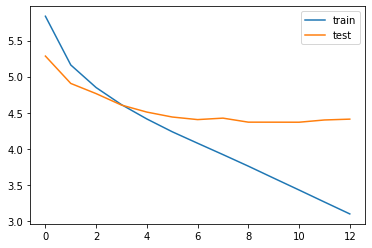

In [51]:
#overcoming memory issues by converting integer sequence into one-hot-vector on fly using sparse categorical cross entropy
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
#early stopping due to the issues of increase in validation loss
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
#training the model in the batch size of 128
#history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=32, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))
#understanding the diagnostic plot
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()

In [52]:
import pickle
tf.keras.models.save_model(model, '/content/drive/MyDrive/nlp_project/')
pickle.dump(model, open('model.pkl', 'wb'))

In [110]:
#model = pickle.load(open('model.pkl', 'rb'))

In [105]:
#building dictionary to convert the index to word for target and source vocabulary
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [106]:
#setting up inference for decoder and encoder
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
encoder_model.summary()
# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_article,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

decoder_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 450)]             0         
                                                                 
 embedding (Embedding)       (None, 450, 500)          22330000  
                                                                 
 lstm (LSTM)                 [(None, 450, 500),        2002000   
                              (None, 500),                       
                              (None, 500)]                       
                                                                 
 lstm_1 (LSTM)               [(None, 450, 500),        2002000   
                              (None, 500),                       
                              (None, 500)]                       
                                                                 
 lstm_2 (LSTM)               [(None, 450, 500),        2002

In [107]:
#function to decode the sequence implementing the inference process
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index!=0:
          sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [108]:
#function to convert an integer sequence to a word sequence for summary and articles
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [109]:
#testing process
for i in range(len(x_val)):
  print("Article:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_article)))
  print("\n")

Article: reports came fly ban shiv sena ravindra gaikwad blacklisted airlines assaulted air india staffer new delhi airport last month may lifted soon party questioned air india chairman managing director clips mein hai raha hai cmd kya hai social media par kar rahe aap rahe toh aap bhi shiv sena sanjay raut said ban likely soon apology letter gaikwad apologised parliament refused say sorry airline officials precondition ani quoted sources saying air india withdraw ban imposed gaikwad ready apologise gaikwad letter gaikwad written letter regret civil aviation minister incident sent speaker office forwarded civil aviation minister looking letters decide course action shiv sena threatened boycott nda meeting april name removed blacklist airlines minister reply satisfactory matter resolved till boycott nda dinner decision taken talking uddhav thackeray raut said zero hour unruly scenes shiv sena members protesting ban even thumping desk civil aviation minister ashok gajapathi raju anger l

KeyboardInterrupt: ignored

In [96]:
#testing of some random articles stored in this new csv file
d=pd.read_csv("/content/drive/MyDrive/nlp_project/test - Sheet1.csv",encoding='latin-1')
cleaned = []
for t in d['ctext']:
    cleaned.append(text_cleaner(t))
d['cleaned']=cleaned
d.dropna(axis=0,inplace=True)

In [97]:
x_train,x_value,y_train,y_value=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True) 

In [104]:
#preprocessing for testing of article
# text = """One month after the United States began what has become a troubled rollout of a national COVID vaccination campaign, the effort is finally gathering real steam.
# Close to a million doses -- over 951,000, to be more exact -- made their way into the arms of Americans in the past 24 hours, the U.S. Centers for Disease Control and Prevention reported Wednesday. That's the largest number of shots given in one day since the rollout began and a big jump from the previous day, when just under 340,000 doses were given, CBS News reported.
# That number is likely to jump quickly after the federal government on Tuesday gave states the OK to vaccinate anyone over 65 and said it would release all the doses of vaccine it has available for distribution. Meanwhile, a number of states have now opened mass vaccination sites in an effort to get larger numbers of people inoculated, CBS News reported."""
x=d['cleaned']
print(type(x))
print(x)
tokenizer=Tokenizer()
tokenizer.fit_on_texts(list(x_train))

thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
tokenizer.fit_on_texts(list(x_train))
#converting text to index vector
x=tokenizer.texts_to_sequences(x)
x=pad_sequences(x, maxlen=max_len_article, padding='post')

reverse_source_word_index=tokenizer.index_word
#printing predicted summaries
for i in range(len(x)):
  print("Article:",seq2text(x[i]))
  print("Predicted summary:",decode_sequence(x[i].reshape(1,max_len_article)))

<class 'pandas.core.series.Series'>
0    speaking cairo guterres route summit bali cop climate conference sharm sheikh said video tweet deeply moved grateful agreement reached istanbul chief also expressed deep commitment remove remainin...
1    high commissioner human rights volker told journalists press conference khartoum military takeover october put end civilian power sharing following ouster former dictator omar bashir left sudan de...
2    year old accused summoned questioning october application submitted shraddha father vikas missing daughter began investigation poonawala clearly thought plan stonewall police hesitate talk live re...
Name: cleaned, dtype: object
% of rare words in vocabulary: 62.325623054703414
Total Coverage of rare words: 5.459945213161783
Article: speaking cairo route summit cop climate conference sheikh said video tweet deeply moved grateful agreement reached istanbul chief also expressed deep commitment remove remaining obstacles exports russian food rema

KeyboardInterrupt: ignored